<a href="https://colab.research.google.com/github/caalinlu/PyTorch/blob/master/%E7%94%A8PyTorch%E5%AE%9E%E7%8E%B0%E5%A4%9A%E5%B1%82%E7%BD%91%E7%BB%9C%EF%BC%88LeNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 神经网络
Autograd实现了反向传播功能，但是直接用来写深度学习的代码在很多情况下还是稍显复杂，torch.nn是专门为神经网络设计的模块化接口。
nn构建于Autograded智商，可以用来定义和运行神经网络。nn.Module是nn中最重要的类，可把它看成是一个网络的封装，包含网络各层定义以及forward方法，调用forward(input)方法，可返回前向传播的结果。下面就以最早的卷积神经网络LeNet为例，来看看如何用nn.Module实现。
这是一个基础的前向传播(feed-forward)网络: 接收输入，经过层层传递运算，得到输出。
### 定义网络
定义网络是，需要继承nn.Module,并实践它的forward方法，把网络中具有可学习参数的层放在构造函数`__init__`中。如果某一层(如ReLU)不具有可学习的参数，则既可以放在构造函数中，也可以不放，但建议不放在其中，而在forward中使用nn.functional代替。

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        # nn.Module子类的函数必须在构造函数中执行父类的构造函数
        # 下式等价于nn.Module.__init__(self)
        super(Net, self).__init__()
        
        # 卷积层‘1’表示输入图片为单通道，‘6’表示输出通道数，‘5’表示卷积核为5
        self.conv1 = nn.Conv2d(1, 6, 5)
        # 卷积层
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 仿射层/全连接层，y = Wx + b
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        # 卷积 -> 激活 -> 池化
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # reshape, '-1'表示自适应
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    


In [32]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


只要在nn.Module的子类中定义了forward函数，backward函数就会自动被实现（利用autograd）。在forward函数中可以使用任何tensor支持的函数，还可以使用if、for循环、print、log等Python语法，写法和标准的Python写法一致。

网络可学习参数通过net.parameters()返回，net.named_parameters可同时返回可学习的参数及名称。

In [33]:
para = list(net.parameters())
print(len(para[9]))

10


In [34]:
for name, parameter in net.named_parameters():
  print(name, ':', parameter.size())

conv1.weight : torch.Size([6, 1, 5, 5])
conv1.bias : torch.Size([6])
conv2.weight : torch.Size([16, 6, 5, 5])
conv2.bias : torch.Size([16])
fc1.weight : torch.Size([120, 400])
fc1.bias : torch.Size([120])
fc2.weight : torch.Size([84, 120])
fc2.bias : torch.Size([84])
fc3.weight : torch.Size([10, 84])
fc3.bias : torch.Size([10])


forward函数的输入和输出都是Tensor。

需要注意的是，torch.nn只支持mini_batches,不支持一次只输入一个样本，即一次必须是一个batch。但如果指向输入一个样本，则用input.unsqueeze(0)将batch_size设为1.例如nn.Conv2d的输入必须是4维的，形如nSamples * nChannel * Height * Width 

## 损失函数

 nn实现了神经网络中大多数的损失函数，例如nn.MSELoss用来计算均方误差，nn.CrossEntropyLoss用来计算交叉熵损失。

In [38]:
input = t.randn(1, 1, 32, 32)
output = net(input)
target = t.arange(0, 10).view(1, 10)
target = target.float()
criterion = nn.MSELoss()
loss = criterion(output, target)
print(loss)

tensor(28.6133, grad_fn=<MseLossBackward>)


In [39]:
# 运行backward， 观察调用之前和调用之后的grad
net.zero_grad() # 把net中所有可学习的参数清零
print('反向传播之前 conv1.bias的梯度')
print(net.conv1.bias.grad)
loss.backward()
print('反向传播之后 conv1.bias的梯度')
print(net.conv1.bias.grad)

反向传播之前 conv1.bias的梯度
None
反向传播之后 conv1.bias的梯度
tensor([ 0.0448, -0.1094, -0.0264,  0.0420,  0.0564,  0.0838])


## 优化器

在反向传播计算完所有参数的梯度后，还需要使用优化方法来更新网络的权重和参数，例如随机梯度下降法(SGD)的更新策略如下：

weight = weight - learning_rate * gradient

**手动实现如下**



```
learning_rate = 0.1

for f in net.parameters():  
    f.data.sub_(f.grad.data * learning_rate)
```



In [0]:
import torch.optim as optim
# 新建一个优化器，设置优化器类型和学习率
op = optim.SGD(net.parameters(), lr = 0.1)


# 首先清零梯度
op.zero_grad()

# 前向传播,计算损失
output = net(input)
loss = criterion(output, target)

# 反向传播
loss.backward()

# 参数调整
op.step()

##  数据加载与预处理


在深度学习中数据加载及预处理是非常复杂繁琐的，但PyTorch提供了一些可极大简化和加快处理流程的工具。同时，对于常用的数据集，PyTorch也提供了封装好的接口供用户快速调用，这些数据集主要保存在torchvision中。
torchvision实现了常用的图像数据加载功能，例如Imagenet、CIFAR10、MNIST等，以及常用的数据转换操作，这极大地方便了数据加载，并且代码具有可重用性。

## 小试牛刀：CIFAR-10分类

In [0]:
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show = ToPILImage() # 可以把Tensor转成Image，方便可视化

In [42]:
# 第一次运行程序torchvision会自动下载CIFAR-10数据集，
# 大约100M，需花费一定的时间，
# 如果已经下载有CIFAR-10，可通过root参数指定

# 定义对数据的预处理
transform = transforms.Compose([
        transforms.ToTensor(), # 转为Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 归一化
                             ])

# 训练集
trainset = tv.datasets.CIFAR10(
                    root='/home/cy/tmp/data/', 
                    train=True, 
                    download=True,
                    transform=transform)

trainloader = t.utils.data.DataLoader(
                    trainset, 
                    batch_size=4,
                    shuffle=True, 
                    num_workers=2)

# 测试集
testset = tv.datasets.CIFAR10(
                    '/home/cy/tmp/data/',
                    train=False, 
                    download=True, 
                    transform=transform)

testloader = t.utils.data.DataLoader(
                    testset,
                    batch_size=4, 
                    shuffle=False,
                    num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

100%|█████████▉| 170459136/170498071 [00:14<00:00, 14320972.23it/s]

Files already downloaded and verified


ship


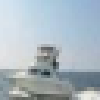

In [43]:
(data, label) = trainset[100]
print(classes[label])

# (data + 1) / 2是为了还原被归一化的数据
show((data + 1) / 2).resize((100, 100))

       bird         cat         car         cat


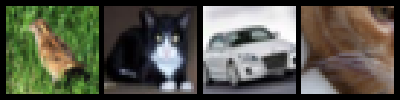

In [44]:
dataiter = iter(trainloader)
# trainloader中batchsize为4，迭代器一次读4张图
images, labels = dataiter.next()
print(' '.join('%11s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images+1)/2)).resize((400,100))

## 定义网络

拷贝上面的LeNet网络，修改self.conv1第一个参数为3通道，因CIFAR-10是3通道彩图

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  
  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(x.size()[0], -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    
    return x
    

In [46]:
net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 定义损失函数和优化器

In [0]:
from torch import optim
criterion = nn.CrossEntropyLoss()
opti = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 训练网络
所有网络的训练流程都类似的，不断地执行如下流程：

*   输入数据
*   前向传播+反向传播
*   更新参数


In [48]:
t.set_num_threads(8)
for epoch in range(2):
  
  running_loss = 0.0
  
  for i, data in enumerate(trainloader, 0):
    
    input, label = data

    # 梯度清零
    opti.zero_grad()
    
    # 输入数据
    output = net(input)
    # 前向传播
    loss = criterion(output, label)
    # 反向传播
    loss.backward()
    
    # 更新参数
    opti.step()
    
    # 打印log参数
    # loss 是一个scalar，需用使用loss.item()来获取值，不能是用loss[0]
    running_loss += loss.item()
    if i % 2000 == 1999:# 每2000个batch打印一下训练状态
        print('[%d, %5d] loss: %.3f' \
                  % (epoch+1, i+1, running_loss / 2000))
        running_loss = 0.0
    

print('Finished Training')    
    


[1,  2000] loss: 2.178
[1,  4000] loss: 1.837
[1,  6000] loss: 1.691
[1,  8000] loss: 1.570
[1, 10000] loss: 1.513
[1, 12000] loss: 1.449
[2,  2000] loss: 1.394
[2,  4000] loss: 1.375
[2,  6000] loss: 1.336
[2,  8000] loss: 1.301
[2, 10000] loss: 1.296
[2, 12000] loss: 1.275
Finished Training


此处训练了2个epoch（遍历完一遍数据集称为一个epoch），来看看网络有没有效果。将测试图片输入到网络中，计算它的label，然后与实际的label进行比较。

实际的label:       cat     ship     ship    plane


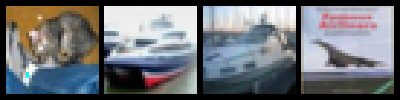

In [49]:
dataiter = iter(testloader)
images, labels = dataiter.next() # 一个batch返回4张图片
print('实际的label: ', ' '.join(\
            '%08s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid(images / 2 - 0.5)).resize((400,100))

In [0]:
correct = 0 # 预测正确的图片数
total = 0 # 

In [58]:
# 计算图片在每个类别上的分数
outputs = net(images)
# 得分最高得那个类
_, predicted = t.max(outputs.data, 1)

print('预测结果: ', ' '.join('%5s'\
            % classes[predicted[j]] for j in range(4)))

预测结果:    cat   car  ship  ship


In [59]:
# 在GPU训练
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")

net.to(device)
images = images.to(device)
labels = labels.to(device)
output = net(images)
loss= criterion(output,labels)

loss

# 如果发现在GPU上并没有比CPU提速很多，实际上是因为网络比较小，GPU没有完全发挥自己的真正实力。

tensor(1.2888, device='cuda:0', grad_fn=<NllLossBackward>)

对PyTorch的基础介绍至此结束。总结一下，本节主要包含一下内容。


1.   Tensor：类似与numpy的array的数据结构，与Numpy的接口类似，可以方便地互相转换。
2.   autograd：为tensor提供自动求导功能
3.   nn：为神经网络设计的接口，提供了很多有用的功能（神经网络层，损失函数，优化器）
4.   神经网络的训练：以CIFAR-10分类为例演示了神经网络的训练流程，包括数据加载,网络搭建，训练，以及测试。
